In [1]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.contrib import distributions

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)

    
def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

'''
If we are not using image augmentation we need to reduce the channels.
'''
def labels_to_maskes_reduce(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)

        channels[..., value[0]] = np.logical_or(channels[:,:, value[0]], mask)


    return channels

def maskes_to_labels(maskes):
    #denne maa muligens fjernes
    maskes = (maskes==maskes.max(axis=2, keepdims=1)).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
        
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        labels = labels + mask[..., None] * value
    
    return labels 

def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

In [4]:
def batch_generator(image_paths, label_path, color_labels, index_list, batch_size, index=0):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths

    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(index_list)
        
        for i in range(batch_size):
            
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
             
            #index = random.randint(0, data_size)
            img_url = image_paths_list[index_list[index]]
            label_url = label_path_list[index_list[index]]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)

            mask = labels_to_maskes_reduce(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

In [5]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'



classes_cc = { #cc = carla cityScape
    0: [0, 0, 0],        # None
    1: [70, 70, 70],     # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],      # Other
    4: [220, 20, 60],    # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],   # RoadLines
    7: [128, 64, 128],   # Roads
    8: [244, 35, 232],   # Sidewalks
    9: [107, 142, 35],   # Vegetation
    10: [0, 0, 255],     # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0]    # TrafficSigns
}

#Create dictonary for id to new id, add color for each id later. 
color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

# read in config file
with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

# print labels
print("There are {} labels in the config file".format(len(labels)))
for label_id, label in enumerate(labels):
    color_id_map[label_id].append(label["color"])
    #print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13

color_label_val_list = get_img_name(color_label_val)
img_val_list = get_img_name(image_val)
print(len(color_label_val_list))
print(len(img_val_list))
#_drivable_id.png
#_drivable_color.png

with open('model_info.json') as a:
    model_info = json.load(a)

for key, value in model_info.items():
    model_info[key]['round'] = 0
    model_info[key]['score'] = 0
    model_info[key]['used_index'] = []
    print(f'Key: {key}, value: {value}')
    print()
    
print('Keys')


There are 66 labels in the config file
2000
2000
Key: u-net_1585114900, value: {'created': 1585114900, 'training_time': 0, 'data_amount': 140, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.17, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': []}

Key: u-net_1585115750, value: {'created': 1585115750, 'training_time': 0, 'data_amount': 144, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'sigmoid', 'dropout': 0.13, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': []}

Key: u-net_1585116680, value: {'created': 1585116680, 'training_time': 0, 'data_amount': 117, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.48, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': []}

Key: u-net_158511877

In [6]:
'''
y: prediction target (solution)
y_hat: prediction
returns: predictions in percentage
'''
def evaluate_prediction(y, y_hat):
    
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    num_correct = y_hat * y
    width, height, _ = num_correct.shape
    max_score = width * height
    score = num_correct.sum()
    return score/max_score

(480, 640, 13)


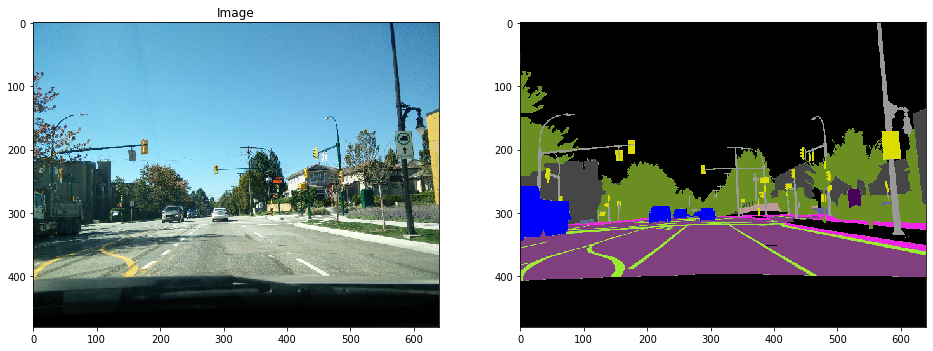

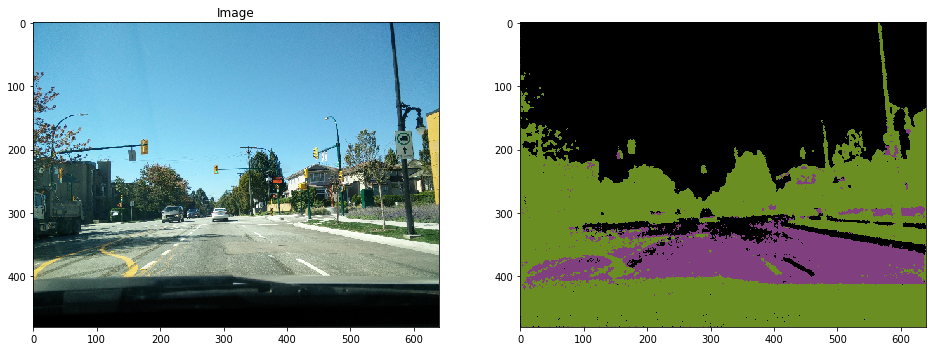

In [7]:
imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
model = load_model(f'seg_models/u-net_1585114900.h5')

img_predicted = model.predict(imges)[0]
target = maskes_to_labels(labels[0]).astype(np.uint8)


print(img_predicted.shape)

y_train_label = maskes_to_labels(img_predicted).astype(np.uint8)
compare_img(imges[0], target, 'Image', 'CityScape labels')
compare_img(imges[0], y_train_label, 'Image', 'CityScape labels')




In [8]:
evaluate_prediction(y=labels[0], y_hat=img_predicted)


0.6199251302083333

## Multiarmed Bandit epilon gredy

In [9]:
epsilon = 0.3
gamma = 0.99
key_list = list(model_info.keys())
num_models = len(key_list)
index_list = range(0, len(img_val_list))
num_trials = len(index_list)
gen = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)
scores = []
score_counter = []

print(f'number of modeles: {num_models}')
print()

def calculate_score(rounds, score, old_score):
    return old_score * ((rounds-1)/rounds) + score *(1/rounds)



def try_model(key, imgs, labels, model_info, round_nr):
    old_score = model_info[key]['score']
    model_info[key]['round'] = model_info[key]['round'] + 1
    rounds = model_info[key]['round']
    
    model = load_model(f'seg_models/{key}.h5')
    y_hat, _, _ = predictions_and_uncetrenty(model, 5, imgs)
    #print(y_hat.shape)
    score = evaluate_prediction(labels[0], y_hat)
    new_score = calculate_score(rounds, score, old_score)
    model_info[key]['score'] = new_score
    model_info[key]['used_index'].append(round_nr)
    return new_score



for i in range(len(index_list)):
    
    
    #print(f'round: {i} of {len(index_list)}')
    imgs, labels = next(gen)
    if random.random() > epsilon:
        
        best_model_key = None
        best_score = -np.inf
        
        for key, value in model_info.items():
            if value['score'] > best_score:
                best_score = value['score']
                best_model_key = key
            
        new_score = try_model(best_model_key, imgs, labels, model_info, i)
    else:
        #explore
        model_key = random.choice(key_list)
        new_score = try_model(model_key, imgs, labels, model_info, i)

    K.clear_session()
    scores.append(new_score)
    #epsilon *= gamma
    
    if i % 10 == 0:
        print(f'round: {i} of {len(index_list)}, score: {sum(score_counter)}')
        score_counter = []
        
        


number of modeles: 136

round: 0 of 2000, score: 0
round: 10 of 2000, score: 0
round: 20 of 2000, score: 0
round: 30 of 2000, score: 0
round: 40 of 2000, score: 0
round: 50 of 2000, score: 0
round: 60 of 2000, score: 0
round: 70 of 2000, score: 0
round: 80 of 2000, score: 0
round: 90 of 2000, score: 0
round: 100 of 2000, score: 0
round: 110 of 2000, score: 0
round: 120 of 2000, score: 0
round: 130 of 2000, score: 0
round: 140 of 2000, score: 0
round: 150 of 2000, score: 0
round: 160 of 2000, score: 0
round: 170 of 2000, score: 0
round: 180 of 2000, score: 0
round: 190 of 2000, score: 0
round: 200 of 2000, score: 0
round: 210 of 2000, score: 0
round: 220 of 2000, score: 0
round: 230 of 2000, score: 0
round: 240 of 2000, score: 0
round: 250 of 2000, score: 0
round: 260 of 2000, score: 0
round: 270 of 2000, score: 0
round: 280 of 2000, score: 0
round: 290 of 2000, score: 0
round: 300 of 2000, score: 0
round: 310 of 2000, score: 0
round: 320 of 2000, score: 0
round: 330 of 2000, score: 0
r

 Avg score pr model: 0.512330909522689


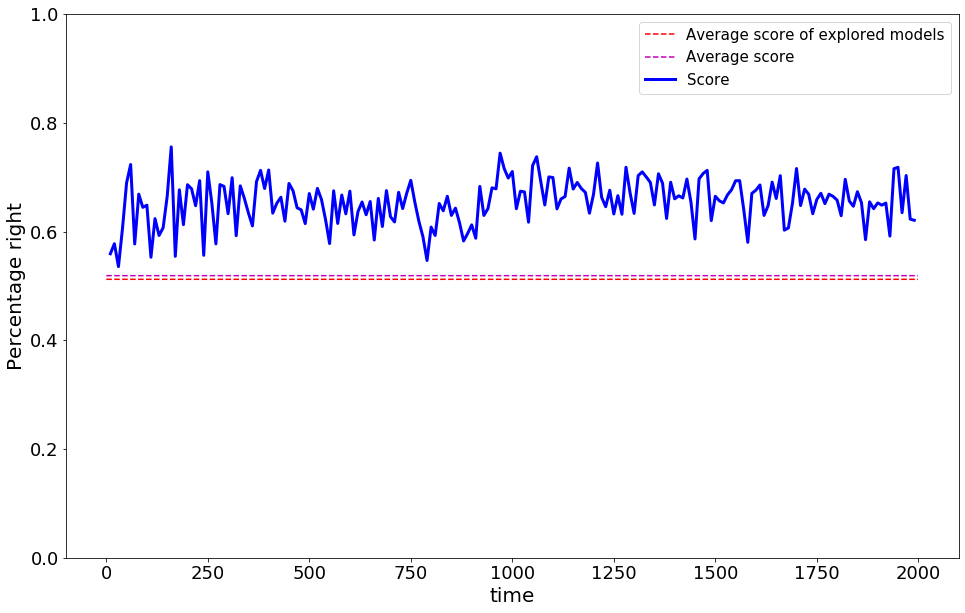

In [20]:




def generalize_list(scores, batch_size):
    score_batch = []
    score_reduced = []
    x_akses = []
    for i in range(len(scores)):
        if i % batch_size == 0 and i != 0:
            score_reduced.append(sum(score_batch)/batch_size)
            score_batch = []
            x_akses.append(i)
        score_batch.append(scores[i])
    return score_reduced, x_akses

def score_graph(scores, model_info, batch_size):
    plt.figure(figsize=(16, 10))
    score_reduced = []


    model_score_avg = 0
    for key, value in model_info.items():
        model_score_avg += value['score']
    model_score_avg = model_score_avg / num_models


    # x_akses is the same in both instances
    score_reduced, x_akses = generalize_list(scores, batch_size)

    
    print(f' Avg score pr model: {model_score_avg}')
    avg = np.array([model_score_avg for i in range(num_trials)])
    avg_explore = np.array([0.519 for i in range(num_trials)]) # 0.5186551321699284
    #plt.bar(, y_akses_list)
    plt.ylim(0,1)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('Percentage right', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.tick_params(axis='both', which='major', labelsize=18)

    plt.plot(avg, 'r--', label='Average score of explored models')
    plt.plot(avg_explore, 'm--', label='Average score')
    plt.plot(x_akses, score_reduced,'b' ,linewidth=3, label='Score')
    
    plt.legend(loc='best', fontsize=15)
    plt.show()
    
score_graph(scores, model_info, 10)

In [11]:

for key, value in model_info.items():
    print(f'Key: {key}, score: {value["score"]} time used: {value["used_index"]}')
    print()

Key: u-net_1585114900, score: 0.5797281901041668 time used: [0, 3, 5, 6, 7, 9, 15, 1787]

Key: u-net_1585115750, score: 0.43352647569444447 time used: [83, 146, 624, 764, 1410, 1446]

Key: u-net_1585116680, score: 0.55998046875 time used: [103, 1536, 1586]

Key: u-net_1585118770, score: 0.6348203125 time used: [598, 599, 600, 1137, 1476]

Key: u-net_1585123137, score: 0.44621826171874995 time used: [189, 439, 802, 1700]

Key: u-net_1585126633, score: 0.641376410590278 time used: [62, 182, 398, 399, 400, 1783]

Key: u-net_1585130481, score: 0.3855240885416667 time used: [663, 706, 1102, 1753]

Key: u-net_1585133766, score: 0.6351236979166668 time used: [374, 375, 376, 578, 1430, 1610]

Key: u-net_1585136637, score: 0.2415218098958333 time used: [160, 179, 534, 589, 903, 1034, 1244, 1249, 1395, 1866]

Key: u-net_1585145765, score: 0.10423068576388889 time used: [234, 1079, 1907]

Key: u-net_1585155175, score: 0.42012369791666665 time used: [107, 215, 514, 716, 1770, 1863, 1983]

Key: u-n

101


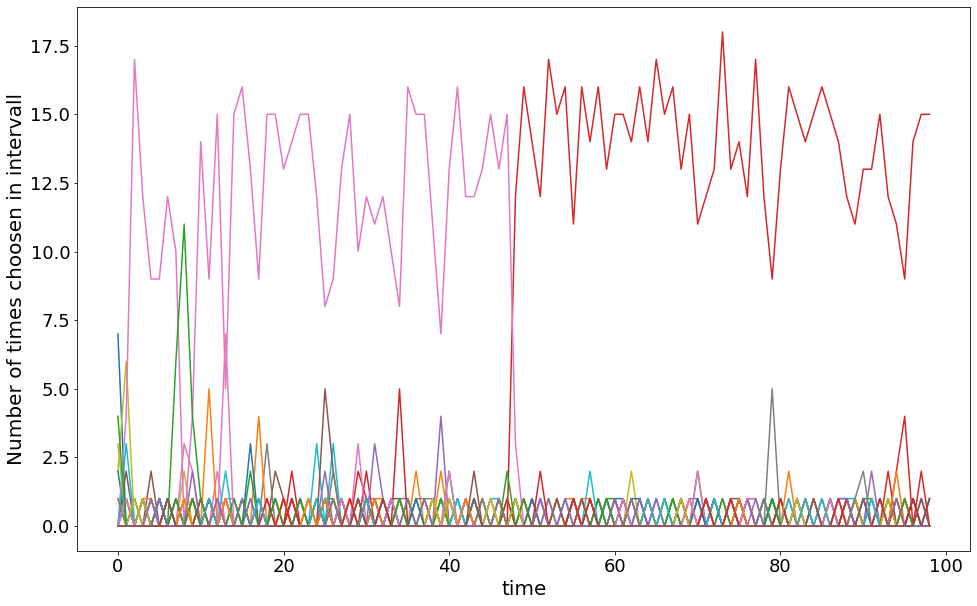

In [21]:

batch_size = 20
model_used = np.zeros((num_models, num_trials), dtype=np.uint8)

smooth = (len(index_list)+batch_size)//batch_size
print(smooth)

counter = 0
for key, value in model_info.items():
    #model_used[counter]
    for index in value['used_index']:
        model_used[counter][index] = 1
    
    counter += 1 

model_used_smoothe = [] #np.zeros((len(key_list), smooth), dtype=np.uint8)
counter = 0
for used in model_used:
    periodic = []
    model_used_smoothe.append([])
    for i in range(len(used)):
        if i % batch_size == 0 and i != 0:
            model_used_smoothe[counter].append(sum(periodic))
            periodic = []
        periodic.append(used[i])
    counter += 1
        

plt.figure(figsize=(16, 10))

for used_per in model_used_smoothe:
    #print(used_per)
    plt.plot(used_per)
#print(model_used_smoothe[5])
#plt.plot(model_used_smoothe[5])
plt.xlabel('time', fontsize=20)
plt.ylabel('Number of times choosen in intervall', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

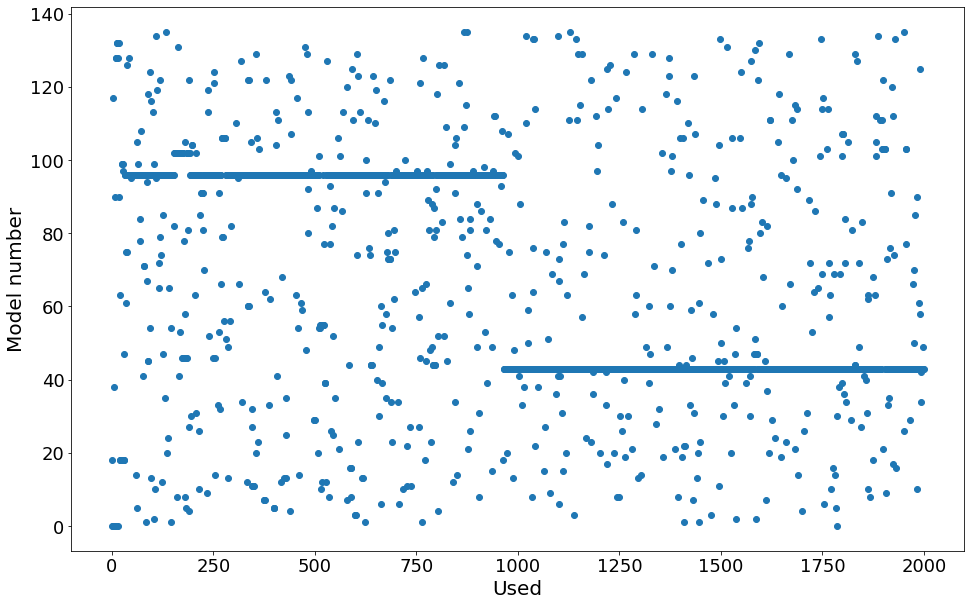

In [22]:
counter = 0
used_list = np.zeros(num_trials)

for key, value in model_info.items():
    for used in value['used_index']:
        used_list[used] = counter
    
    counter += 1
counter_list = range(num_trials)
plt.figure(figsize=(16, 10))

plt.xlabel('Used', fontsize=20)
plt.ylabel('Model number', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.scatter(counter_list, used_list)
plt.show()

In [14]:
print('Average ressults') #0.3, 0.2
print(f'Score: {np.array(scores).mean()}') #0.6542642820046288


Average ressults
Score: 0.6542642820046288


In [23]:
print(scores)

[0.5682975260416666, 0.5546744791666667, 0.48083658854166667, 0.5884814453125, 0.4248958333333333, 0.6483235677083333, 0.6479817708333333, 0.5798899739583334, 0.5345572916666667, 0.5652625868055556, 0.6502864583333333, 0.6002164713541667, 0.63974609375, 0.6090429687500001, 0.5707031250000001, 0.5464136904761906, 0.546433376736111, 0.54006591796875, 0.4635953776041667, 0.6107942708333334, 0.38689453125, 0.6582769097222223, 0.6914982096354167, 0.6078346354166667, 0.6023372395833333, 0.5717290581597223, 0.6136328124999999, 0.5643066406249999, 0.09528645833333334, 0.5645470610119048, 0.5504752604166666, 0.582889404296875, 0.827333984375, 0.673916015625, 0.760703125, 0.244228515625, 0.5065006510416666, 0.43698567708333336, 0.736970486111111, 0.74467529296875, 0.7617779947916667, 0.7547146267361112, 0.7535686383928573, 0.55765625, 0.7533170572916668, 0.7555924479166667, 0.7568483072916667, 0.7432708925189394, 0.30978841145833336, 0.7510500759548611, 0.757011217948718, 0.7476688058035714, 0.7